## Final Model -- Facial Keypoint Prediction

In this notebook, we walk through a model from the tutorial referenced by the official Kaggle competition website. It was constructed by Daniel Nouri. We will use this model as the baseline of our final project.

### 0. Fire up Neural Nets Libraries

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer
    
np.random.seed(42)

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Path

We will further split the provided training data into our training set and development set in step 4.

In [2]:
#FTRAIN = '~/data/training.csv'
#FTEST = '~/data/test.csv'
FTRAIN = "C:\\Users\\Jennifer\\Documents\\Berkeley\\W207\\Projects\\final_team\\training.csv"
FTEST = "C:\\Users\\Jennifer\\Documents\\Berkeley\\W207\\Projects\\final_team\\test.csv"
FLOOKUP = '~/data/IdLookupTable.csv'

IDXTRAIN = "C:\\Users\\Jennifer\\Documents\\Berkeley\\W207\\Projects\\final_team\\train_indices.txt"
IDXDEV = "C:\\Users\\Jennifer\\Documents\\Berkeley\\W207\\Projects\\final_team\\dev_indices.txt"

### 2. View Raw Data

In [3]:
# Each row of our data refers to one face. 
# The first 30 columns refers to the labels of different facial keypoints. 
# A feature vector in the last column store pixel values of the facial image.

read_csv(FTRAIN).head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [4]:
# Testing data has no targets available
read_csv(FTEST).head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


### 3. Transforming Data

In [4]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load(test = False, dev = False,cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    fname = FTEST if test else FTRAIN
    df = read_csv((fname)) #Load pandas dataframe
    
    if (not test) and dev:
        load_idx = [int(line.rstrip('\n')) for line in open(IDXDEV)]
    elif (not test) and (not dev):    
        load_idx = [int(line.rstrip('\n')) for line in open(IDXTRAIN)]       
    
    if load_idx: df = df.loc[load_idx]
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna()

    # drop all rows that have missing values in them. 
    # if argument cols in not specified, this reduce from 7049 partial to 2140 full examples
    # potentially a problem training a neural net with fewer examples
    # should consider data augmentation in upcoming models
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid
    
    # Loading the 30 labels(targets)(keypoints) y for each face into an array
    if not test: # only training examples have target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle training data
        y = y.astype(np.float32)
        
    else:
        y = None # development data has no targets available
        
    return X,y,df.index

In [5]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(test=False, dev=False, cols=None):
    X, y, idx = load(test=test, dev=dev, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    #print (X)
    return X, y, idx

In [6]:
X, y,IDXTRAIN  = load2d()

left_eye_center_x            6839
left_eye_center_y            6839
right_eye_center_x           6836
right_eye_center_y           6836
left_eye_inner_corner_x      2071
left_eye_inner_corner_y      2071
left_eye_outer_corner_x      2067
left_eye_outer_corner_y      2067
right_eye_inner_corner_x     2068
right_eye_inner_corner_y     2068
right_eye_outer_corner_x     2068
right_eye_outer_corner_y     2068
left_eyebrow_inner_end_x     2070
left_eyebrow_inner_end_y     2070
left_eyebrow_outer_end_x     2025
left_eyebrow_outer_end_y     2025
right_eyebrow_inner_end_x    2070
right_eyebrow_inner_end_y    2070
right_eyebrow_outer_end_x    2036
right_eyebrow_outer_end_y    2036
nose_tip_x                   6849
nose_tip_y                   6849
mouth_left_corner_x          2069
mouth_left_corner_y          2069
mouth_right_corner_x         2070
mouth_right_corner_y         2070
mouth_center_top_lip_x       2075
mouth_center_top_lip_y       2075
mouth_center_bottom_lip_x    6816
mouth_center_b

### 4. Splitting into training and development set

In [42]:
! pip install --upgrade sklearn

Requirement already up-to-date: sklearn in c:\users\jennifer\anaconda2\envs\mlpy\lib\site-packages
Requirement already up-to-date: scikit-learn in c:\users\jennifer\anaconda2\envs\mlpy\lib\site-packages (from sklearn)


In [32]:
! print(sklearn.__version__) 

Unable to initialize device PRN


In [40]:
! pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\jennifer\anaconda2\envs\mlpy\lib\site-packages


In [43]:
!source activate py36; pip install --upgrade sklearn

'source' is not recognized as an internal or external command,
operable program or batch file.


In [44]:
!pip3 install --upgrade sklearn

'pip3' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
from sklearn import model_selection
# help(model_selection.train_test_split)
# keep random state = 0 -- we need the same development set to compare our Baseline with other models
X_train, X_dev, y_train, y_dev, train_idx, test_idx = model_selection.train_test_split(X, y, range(len(X)), test_size=200, random_state=0)
(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

# There are 1940 training examples and 200 development examples

((1740, 1, 96, 96), (200, 1, 96, 96), (1740, 30), (200, 30))

In [9]:
# double check if random state is producing the same split
train_idx[100] == 1410

False

In [10]:
X_train.shape

(1740, 1, 96, 96)

In [67]:
test =X_train[[0,0]]
test.shape

(2, 1, 96, 96)

In [72]:
test =X_train[[0]]
test.shape
test

array([[[[ 0.03137255,  0.03529412,  0.02745098, ...,  0.13725491,
           0.12156863,  0.08235294],
         [ 0.02352941,  0.02745098,  0.02352941, ...,  0.10196079,
           0.09411765,  0.10980392],
         [ 0.02745098,  0.03137255,  0.03137255, ...,  0.07450981,
           0.07843138,  0.0627451 ],
         ..., 
         [ 0.03921569,  0.04313726,  0.04313726, ...,  0.72156864,
           0.68627453,  0.67843139],
         [ 0.03529412,  0.04313726,  0.05882353, ...,  0.7019608 ,
           0.68627453,  0.67843139],
         [ 0.03921569,  0.05098039,  0.07843138, ...,  0.70588237,
           0.70588237,  0.69803923]]]], dtype=float32)

### 5.0 Data Augmentation

### 5.1.1 General blurring, whole image

In [7]:
import copy
# generalized blurring function
# X is a single row of image data
# r is the radius of blurring (averages all pixels up-down-left-right of iteration of pixels)
# avoids borders for simplicity
# called in other blurring functions

def blur_range(X,r,i_range,j_range):
    if r>=0 and r<11:

        fig=copy.deepcopy(X)  # for protection

        horz_moves=range(-r,r+1) # all possible movements in i-direction (rows) from pixel
        vert_moves=range(-r,r+1) # same for j-direction (columns)
        
        horz_canvas=i_range
        vert_canvas=j_range

        Arr = np.reshape(fig,(96,96)) # creates np 96x96 array to work with

        for i in horz_canvas:  # scan X columns, stay in bounds, dont care about edges (sorry)
            for j in vert_canvas:  #scan Y rows, stay in bounds

                area=[]                        # blank list for area pixel vals
                for rows in horz_moves:        # row cycle 
                    for cols in vert_moves:      # col cycle
                        area.append(Arr[i+rows,j+cols])      #keep appending area list with vals
                Arr[i,j]=np.mean(area)   

        return np.ravel(Arr)

    else: 
        print('radius between 0 and 10')
        
# blur entire picture 
def blur_radius(X,r):
    
    i_range=range(r,96-r) # scan X columns, stay in bounds, dont care about edges (sorry)
    j_range=range(r,96-r)#scan Y rows, stay in bounds
    
    return blur_range(X,r,i_range,j_range)

In [ ]:
#blurring with radius 1 to maintain some image distinction
X_train_blur=np.apply_along_axis(blur_radius,1,X_train,1)

#X_train_blur=np.apply_along_axis(train_blur,1,X_dev,1)

### 5.2 Contrast (fingerprint motif)

In [27]:
# f is a contrast factor: 1/f addition or subtraction if higher or lower than area mean (1 pixel in all directions)
# resulting patter looks like fingerprint contours on image
def contrast_b(X,f):
    
    
    Arr=(X)  # for protection
    
    Arr = np.reshape(Arr,(96,96)) # creates np 96x96 array to work with 
    Arr_out=np.zeros((96,96))   # blank array to fill in values

    for i in range(1,95):  # scan X columns, stay in bounds, dont care about edges (sorry)
        for j in range(1,95):  #scan Y rows, stay in bounds

            area=[]                        # blank list for area pixel vals
            for rows in range(-1,2):        # row cycle 
                for cols in range(-1,2):      # col cycle
                    area.append(Arr[i+rows,j+cols])      #keep appending area list with vals
            
            
            if np.mean(area)< Arr[i,j]:
                Arr_out[i,j]= Arr[i,j] + (1-Arr[i,j])/f
            else:
                Arr_out[i,j]= Arr[i,j] - (1-Arr[i,j])/f

    return np.ravel(Arr_out)
    

In [31]:
! pip install copy

  Could not find a version that satisfies the requirement copy (from versions: )
No matching distribution found for copy


In [32]:
import copy

In [28]:
#X_train_blur=np.apply_along_axis(blur_radius,1,X_train,1)
X_train_finger = np.empty([len(X_train),9216])
#apply transformation
for i in range(0,len(X_train)):
    #pick an image to mess with
    img = X_train[[i]] #.reshape(96,96)
    #call function
    result = contrast_b(img,4)
    X_train_finger[i] = result.reshape(1, 9216)/255

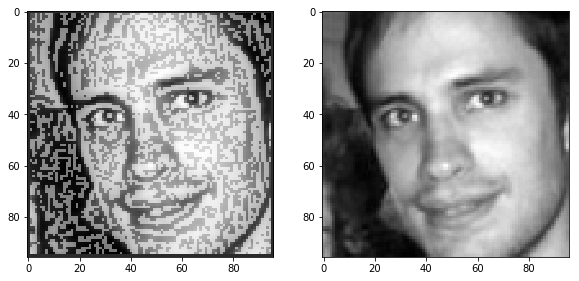

In [29]:
###########################
#pick an image to mess with
img = X_train[1000].reshape(96,96)

#check transformation
img_trans = X_train_finger[1000].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,2).imshow(img,cmap='gray')
fig.add_subplot(1,3,1).imshow(img_trans,cmap='gray')

In [30]:
X_train_finger = X_train_finger.reshape(-1, 1, 96, 96)

In [31]:
X_train_finger[[3]]
X_train_finger.shape

(1740, 1, 96, 96)

In [32]:
print(X_train_finger.max())
print(X_train_finger.min())

0.00392156862745
-0.000980392156863


In [33]:
X_train_finger[[2]]

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.00015379, -0.00013456, ...,  0.00344098,
           0.00344098,  0.        ],
         [ 0.        ,  0.0016609 ,  0.00174164, ...,  0.00346021,
           0.00364475,  0.        ],
         ..., 
         [ 0.        ,  0.00350634,  0.00348328, ...,  0.00302191,
           0.00324106,  0.        ],
         [ 0.        ,  0.0032872 ,  0.00324875, ...,  0.00273356,
           0.00303345,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]])

In [34]:
X_train_finger2 = np.subtract(X_train_finger,X_train_finger.min())
X_train_finger2[[0]]

array([[[[ 0.00098039,  0.00098039,  0.00098039, ...,  0.00098039,
           0.00098039,  0.00098039],
         [ 0.00098039,  0.00013456,  0.00011534, ...,  0.00049981,
           0.00046136,  0.00098039],
         [ 0.00098039,  0.00205306,  0.00015379, ...,  0.00036524,
           0.00219146,  0.00098039],
         ..., 
         [ 0.00098039,  0.00021146,  0.00021146, ...,  0.00408305,
           0.00336409,  0.00098039],
         [ 0.00098039,  0.00021146,  0.00213379, ...,  0.00344098,
           0.00336409,  0.00098039],
         [ 0.00098039,  0.00098039,  0.00098039, ...,  0.00098039,
           0.00098039,  0.00098039]]]])

In [35]:
print(X_train_finger2.max())
print(X_train_finger2.min())

0.00490196078431
0.0


In [ ]:
#apply contrast function along axis, using factor 1/4 addition/substraction for balanced contrast. 

X_train_contrast_b=np.apply_along_axis(contrast_b,1,X_train,4)

#X_dev_contrast_b=np.apply_along_axis(contrast_b,1,X_dev,4)

### 5.3 Flipping half of the image on the fly

In [2]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

NameError: name 'read_csv' is not defined

In [6]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

### 5.x stack transformed training sets into one training_x label_y

In [ ]:
# make sure each X_train_transform is accompanied by a y_train in the stack 

X_train_combo=np.vstack((X_train_blur,X_train_contrast_b))
y_train_combo=np.vstack((y_train,y_train))
    
# if total size not the same, del each combo array
# we could place checks on each vstack operation, but production sets would be controlled and predictable
if X_train_combo.shape[0]!=y_train_combo.shape[0]:
    del X_train_combo
    del Y_train_combo

### 5.5 Adaptive filter transformation 9x9

 run time (H:M:S) 00:00:04


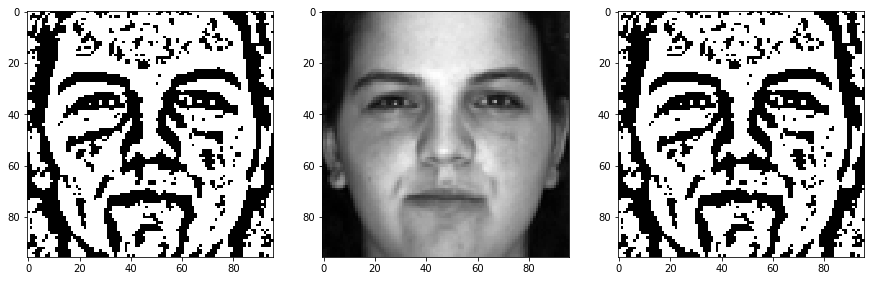

In [68]:
import scipy.misc
import cv2
import time
%matplotlib inline
#Applying an adaptive filter (considers a 9x9 grid of neighbors)
#can mess with the 9 as a parameter
#pick an image to mess with & reformat it
def render(img):
    im = scipy.misc.toimage(img.reshape(96,96))
    im.save("foobar.png")
    src = cv2.imread("foobar.png", 0)
    img_edge = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
    return(img_edge)

#starts the timer
start_time = time.time()

#X_train_blur=np.apply_along_axis(blur_radius,1,X_train,1)
df_train_trans2 = np.empty([len(X_train),9216])
#apply transformation
for i in range(0,len(X_train)):
    #pick an image to mess with
    img = X_train[[i]] #.reshape(96,96)
    #call function
    result = render(img)
    df_train_trans2[i] = result.reshape(1, 9216)/255
    # old shape .reshape(1, 9216) | reshape(-1, 1, 96, 96)
   # print (df_train_trans[i])
#mini_train_transformed = mini_train_data.applymap(render)
#mini_train_transformed = np.hstack(mini_train_transformed['Image'].values).T  # scale pixel values to [0, 1]#T transposes the col

#stop timer
end_time = time.time()
run_time = time.strftime("%H:%M:%S",time.gmtime(end_time - start_time))
print (' run time (H:M:S) ' + str(run_time))


###########################
#pick an image to mess with
img = X_train[27].reshape(96,96)

#pick an image to mess with and transform it mannually
img_o = X_train[27].reshape(96,96)
#call function
result = render(img_o)

#check transformation
img_trans = df_train_trans2[27].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,2).imshow(img,cmap='gray')
fig.add_subplot(1,3,1).imshow(img_trans,cmap='gray')
fig.add_subplot(1,3,3).imshow(result,cmap='gray')

In [69]:
df_train_trans2.shape

(1740, 9216)

In [70]:
df_train_tran3 = df_train_trans2.reshape(-1, 1, 96, 96)
df_train_tran3.shape

(1740, 1, 96, 96)

In [106]:
df_train_tran3[[0]].shape
df_train_tran3[[0]]

array([[[[ 1.,  1.,  1., ...,  1.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  1.,  1.],
         [ 0.,  1.,  1., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ...,  0.,  1.,  1.]]]])

### 5.6 Adaptive filter transformation 3x3

 run time (H:M:S) 00:00:04


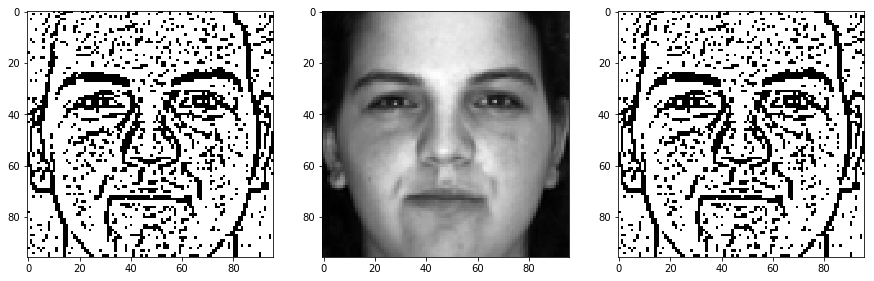

In [14]:
import scipy.misc
import cv2
import time
%matplotlib inline
#Applying an adaptive filter (considers a 9x9 grid of neighbors)
#can mess with the 9 as a parameter
#pick an image to mess with & reformat it
def render(img):
    im = scipy.misc.toimage(img.reshape(96,96))
    im.save("foobar.png")
    src = cv2.imread("foobar.png", 0)
    img_edge = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 2)
    return(img_edge)

#starts the timer
start_time = time.time()

#X_train_blur=np.apply_along_axis(blur_radius,1,X_train,1)
X_train_adaptive3x3 = np.empty([len(X_train),9216])
#apply transformation
for i in range(0,len(X_train)):
    #pick an image to mess with
    img = X_train[[i]] #.reshape(96,96)
    #call function
    result = render(img)
    X_train_adaptive3x3[i] = result.reshape(1, 9216)/255

#stop timer
end_time = time.time()
run_time = time.strftime("%H:%M:%S",time.gmtime(end_time - start_time))
print (' run time (H:M:S) ' + str(run_time))


###########################
#pick an image to mess with
img = X_train[27].reshape(96,96)

#pick an image to mess with and transform it mannually
img_o = X_train[27].reshape(96,96)
#call function
result = render(img_o)

#check transformation
img_trans = X_train_adaptive3x3[27].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,2).imshow(img,cmap='gray')
fig.add_subplot(1,3,1).imshow(img_trans,cmap='gray')
fig.add_subplot(1,3,3).imshow(result,cmap='gray')

#convert to the proper format
X_train_adaptive3x3 = X_train_adaptive3x3.reshape(-1, 1, 96, 96)

In [72]:
X_train_adaptive3x3[[0]].shape

(1, 1, 96, 96)

### 5.7 Inverse Blur Transformation

 run time (H:M:S) 00:00:00


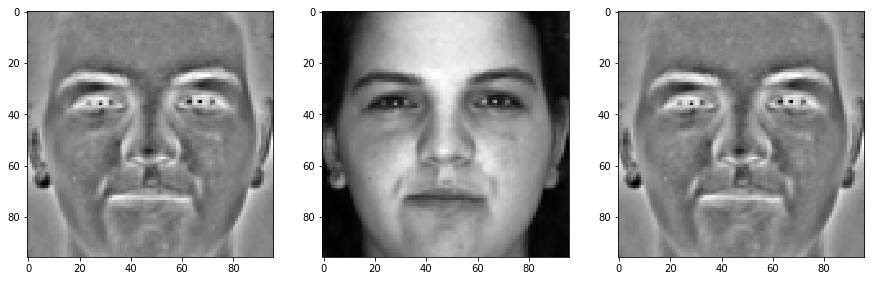

In [15]:
#function to transform the images
def render(img):
    img_inv = 255 - img #inverts the colors
    img_blur = cv2.GaussianBlur(img_inv, (21,21), 0, 0) #heavy blur on the inverse
    img_blend = cv2.divide(img_inv, img_blur, scale=256) #merges the strong blur with the inverted colors
    return img_blend

#starts the timer
start_time = time.time()

X_train_invBlur = np.empty([len(X_train),9216])
#apply transformation
for i in range(0,len(X_train)):
    #pick an image to mess with
    img = X_train[[i]].reshape(96,96)
    #call function
    result = render(img)
    X_train_invBlur[i] = result.reshape(1, 9216)/255
   # print (df_train_trans[i])
#mini_train_transformed = mini_train_data.applymap(render)
#mini_train_transformed = np.hstack(mini_train_transformed['Image'].values).T  # scale pixel values to [0, 1]#T transposes the col

#stop timer
end_time = time.time()
run_time = time.strftime("%H:%M:%S",time.gmtime(end_time - start_time))
print (' run time (H:M:S) ' + str(run_time))


###########################
#pick an image to mess with
img = X_train[27].reshape(96,96)

#pick an image to mess with and transform it mannually
img_o = X_train[27].reshape(96,96)
#call function
result = render(img_o)

#check transformation
img_trans = X_train_invBlur[27].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,2).imshow(img,cmap='gray')
fig.add_subplot(1,3,1).imshow(img_trans,cmap='gray')
fig.add_subplot(1,3,3).imshow(result,cmap='gray')

In [16]:
X_train_invBlur = X_train_invBlur.astype(np.float32)

In [17]:
X_train_invBlur[[0]]

array([[ 1.00392044,  1.00390518,  1.00393653, ...,  1.00396931,
         1.00395775,  1.00398469]], dtype=float32)

In [18]:
#convert to the proper format
X_train_invBlur  = X_train_invBlur.reshape(-1, 1, 96, 96)
print(X_train_invBlur.max())
print(X_train_invBlur.min())
X_train_invBlur2 = np.subtract(X_train_invBlur,0.15)
X_train_invBlur2[[0]]

1.00712
1.00032


array([[[[ 0.85392046,  0.8539052 ,  0.85393655, ...,  0.85379684,
           0.8538363 ,  0.85398328],
         [ 0.85395181,  0.85393667,  0.85395241, ...,  0.85393143,
           0.85394013,  0.85387075],
         [ 0.85393763,  0.85392225,  0.85392261, ...,  0.85402715,
           0.85398996,  0.8540442 ],
         ..., 
         [ 0.85397756,  0.85396433,  0.85397041, ...,  0.85390627,
           0.85403395,  0.85406089],
         [ 0.85399771,  0.85396898,  0.85391414, ...,  0.85398459,
           0.85403478,  0.85406172],
         [ 0.85398376,  0.85393989,  0.85383868, ...,  0.85396934,
           0.85395777,  0.85398471]]]], dtype=float32)

In [19]:
X_train_invBlur2 = np.divide(X_train_invBlur,X_train_invBlur.max())
X_train_invBlur2[[0]]
#plt.plot(X_train_invBlur2[[0]])
#X_train_invBlur[[0]].shape

array([[[[ 0.99682528,  0.99681014,  0.99684125, ...,  0.99670255,
           0.99674171,  0.99688768],
         [ 0.99685639,  0.99684137,  0.99685699, ...,  0.99683619,
           0.99684483,  0.99677593],
         [ 0.99684232,  0.99682707,  0.99682742, ...,  0.9969312 ,
           0.9968943 ,  0.99694812],
         ..., 
         [ 0.99688196,  0.99686885,  0.99687487, ...,  0.99681121,
           0.99693799,  0.99696469],
         [ 0.99690199,  0.99687344,  0.99681902, ...,  0.996889  ,
           0.99693882,  0.99696553],
         [ 0.99688816,  0.99684459,  0.9967441 , ...,  0.9968738 ,
           0.99686235,  0.99688905]]]], dtype=float32)

In [20]:
print(X_train_invBlur2.max())
print(X_train_invBlur2.min())
print(X_train_invBlur2.shape)

1.0
0.993247
(1740, 1, 96, 96)


### Merging Data Augmentation

In [ ]:
X_augmented = X_train_invBlur

## APPLYING BASIC NEURAL NET

In [22]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
def float32(k):
    return np.cast['float32'](k)


class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
            
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10,
    verbose=1,
    )

SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

SPECIALIST_NAMES = ["eye_center", "nose_tip", "mouth_corner", "mouth_center", "eye_corner", "eyebrow"]
SPECIALIST_OUTPUTNODES = [4,2,6,2,8,8]

### Baseline NN -- No transformation

In [79]:
net12_augmented = clone(net12)
net12_augmented.max_epochs = 50

net12_augmented.load_params_from("C:/Users/Jennifer/Documents/Berkeley/W207/Projects/final_team/data/net_pretrain_saved_params.txt")
# put in your own augmented and transformed data
net12_augmented.fit(X_train, y_train)

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet m

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   100

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x0000006CB21E57F0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x0000006CB21E5D30>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

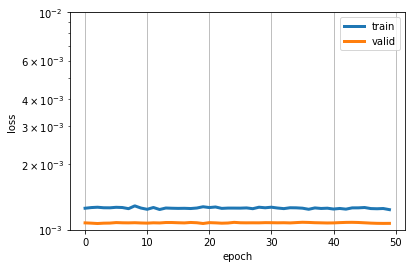

In [80]:
train_loss = np.array([i["train_loss"] for i in net12_augmented.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net12_augmented.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [81]:
### 5.1 NN accuracy

In [36]:
net12_augmented4 = clone(net12)
net12_augmented4.max_epochs = 50

net12_augmented4.load_params_from("C:/Users/Jennifer/Documents/Berkeley/W207/Projects/final_team/data/net_pretrain_saved_params.txt")
# put in your own augmented and transformed data
net12_augmented4.fit(X_train_finger2, y_train)

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet m

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   100

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000C0033010B8>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x000000C002037EF0>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

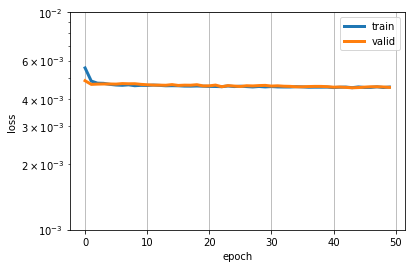

In [37]:
train_loss = np.array([i["train_loss"] for i in net12_augmented4.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net12_augmented4.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

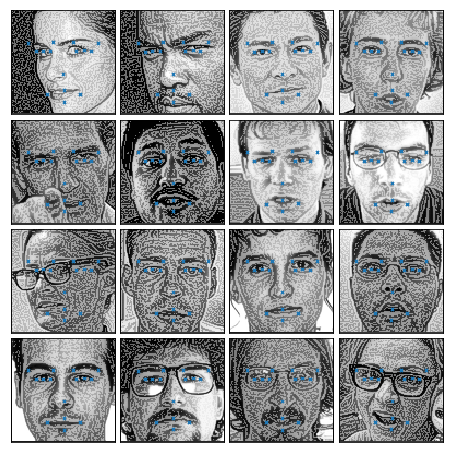

In [40]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

#df_train_tran3, _ = load(test=True)
y_pred = net12_augmented4.predict(X_train_finger2)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_train_finger2[i], y_pred[i], ax)

pyplot.show()

### Transformation 1: Adaptive filter 9x9 

In [83]:
net12_augmented5 = clone(net12)
net12_augmented5.max_epochs = 50

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet m

In [84]:
net12_augmented5.load_params_from("C:/Users/Jennifer/Documents/Berkeley/W207/Projects/final_team/data/net_pretrain_saved_params.txt")

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).


In [85]:
# put in your own augmented and transformed data
net12_augmented5.fit(df_train_tran3, y_train)

# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    30

# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -------
      1     0.0056

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x0000006CB1FA4A20>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x0000006CB1FA48D0>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

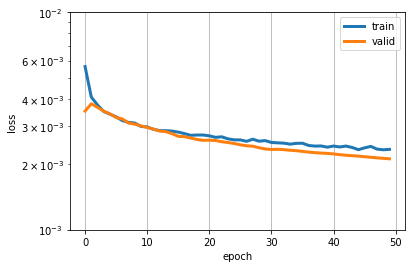

In [86]:
import matplotlib.pyplot as pyplot
train_loss = np.array([i["train_loss"] for i in net12_augmented5.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net12_augmented5.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

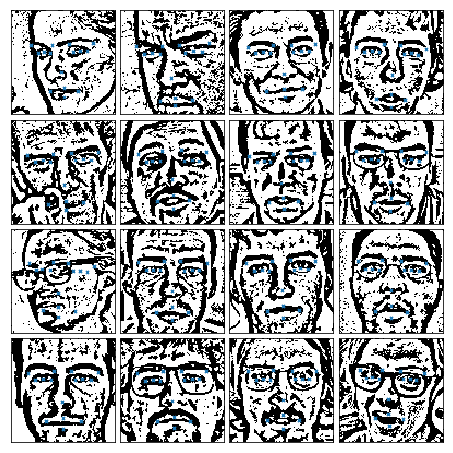

In [87]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

#df_train_tran3, _ = load(test=True)
y_pred = net12_augmented5.predict(df_train_tran3)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(df_train_tran3[i], y_pred[i], ax)

pyplot.show()

### Transformation 2: Adaptive filter 3x3

In [88]:
net12_augmented2 = clone(net12)
net12_augmented2.max_epochs = 50

net12_augmented2.load_params_from("C:/Users/Jennifer/Documents/Berkeley/W207/Projects/final_team/data/net_pretrain_saved_params.txt")
# put in your own augmented and transformed data
net12_augmented2.fit(X_train_adaptive3x3, y_train)

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet m

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   100

     50     0.00203     0.00188    1.08141  189.59s
     50     0.00203     0.00188    1.08141  189.59s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x0000006C8F079780>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x0000006C8F079B70>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

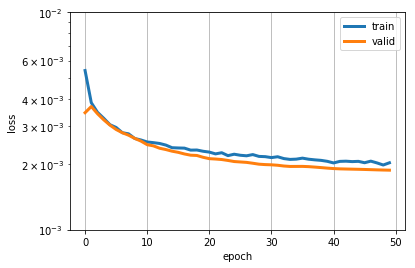

In [89]:
train_loss = np.array([i["train_loss"] for i in net12_augmented2.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net12_augmented2.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

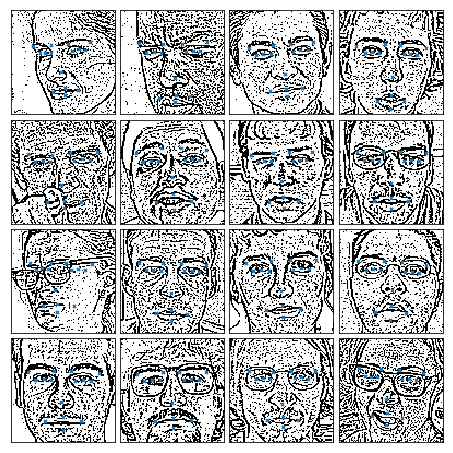

In [90]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

#df_train_tran3, _ = load(test=True)
y_pred = net12_augmented2.predict(X_train_adaptive3x3)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_train_adaptive3x3[i], y_pred[i], ax)

pyplot.show()

### Transformation 3: InverseBlur

In [23]:
net12_augmented3 = clone(net12)
net12_augmented3.max_epochs = 50

net12_augmented3.load_params_from("C:/Users/Jennifer/Documents/Berkeley/W207/Projects/final_team/data/net_pretrain_saved_params.txt")
# put in your own augmented and transformed data
net12_augmented3.fit(X_train_invBlur2, y_train)

C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\Jennifer\Anaconda2\envs\MLpy\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator NeuralNet m

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   100

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000C0230EAEB8>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x000000C0230EA5C0>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

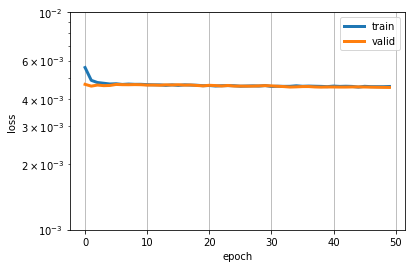

In [24]:
import matplotlib.pyplot as pyplot
train_loss = np.array([i["train_loss"] for i in net12_augmented3.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net12_augmented3.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

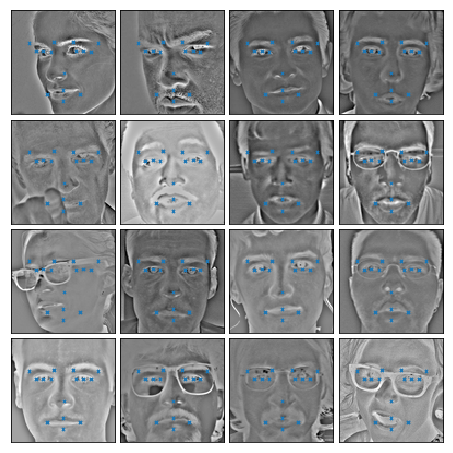

In [26]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

#df_train_tran3, _ = load(test=True)
y_pred = net12_augmented3.predict(X_train_invBlur2)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_train_invBlur2[i], y_pred[i], ax)

pyplot.show()